### Classification using gradient boosting

## Importation of librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from itertools import combinations
from sklearn.feature_selection import SelectKBest, f_classif
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
from mlxtend.evaluate import bias_variance_decomp

from sklearn.ensemble import AdaBoostClassifier as AdaBoost
from xgboost import XGBClassifier 
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
data1 = pd.read_csv('Data_Preprocessed1/data_1.csv')
data2 = pd.read_csv('Data_Preprocessed1/data_2.csv')
data3 = pd.read_csv('Data_Preprocessed1/data_3.csv')
data4 = pd.read_csv('Data_Preprocessed1/data_4.csv')
data5 = pd.read_csv('Data_Preprocessed1/data_5.csv')

datasets = [data1, data2, data3, data4, data5]

# for each data drop 'start_index','end_index' columns
for data in datasets:
    data.drop(['start_index', 'end_index'], axis=1, inplace=True)

In [3]:
datasets[1].head()

,mean_ax,mean_ay,mean_az,rms_ax,rms_ay,rms_az,std_ax,std_ay,std_az,smv_mean,...,iqr_ax,iqr_ay,iqr_az,max_min_ax,max_min_ay,max_min_az,mean_freq_power_ax,mean_freq_power_ay,mean_freq_power_az,label
0,-0.113839,-0.037810,0.174019,0.782822,1.325804,1.101381,0.774501,1.325265,1.087547,1.737313,...,0.655396,1.943828,1.389800,3.14364,6.06237,4.25199,3.413769,5.579243,4.841513,1
1,-0.102130,0.021296,0.213069,0.779976,1.332000,1.114263,0.773260,1.331830,1.093702,1.748419,...,0.655396,1.986949,1.350880,3.14364,6.06237,4.25199,3.437519,5.653065,4.684640,1
2,-0.083340,0.063929,0.246829,0.779767,1.328696,1.122340,0.775300,1.327158,1.094862,1.751474,...,0.908761,2.023249,1.355168,3.14364,6.06237,4.25199,3.497695,5.681316,4.540320,1
3,-0.070193,0.099465,0.263319,0.776878,1.321629,1.123340,0.773701,1.317881,1.092042,1.741510,...,0.906331,1.943291,1.355168,3.14364,6.06237,4.25199,3.396067,5.776409,4.422067,1
4,-0.060204,0.113357,0.265732,0.778233,1.312167,1.122721,0.775900,1.307261,1.090820,1.729366,...,0.955703,1.849708,1.327816,3.14364,6.06237,4.25199,3.405728,5.691682,4.394112,1


In [4]:
df = pd.concat(datasets, ignore_index=True)
X = df.drop('label', axis=1)
y = df['label']

In [5]:
X.head()

,mean_ax,mean_ay,mean_az,rms_ax,rms_ay,rms_az,std_ax,std_ay,std_az,smv_mean,...,smv_min,iqr_ax,iqr_ay,iqr_az,max_min_ax,max_min_ay,max_min_az,mean_freq_power_ax,mean_freq_power_ay,mean_freq_power_az
0,0.012984,0.062622,0.023608,0.163585,1.081450,1.171914,0.163069,1.079636,1.171676,1.341920,...,0.127501,0.249617,1.825086,1.711199,0.660868,3.80449,4.49119,0.796949,4.716595,5.063013
1,0.018898,0.038167,0.060802,0.160526,1.064526,1.146281,0.159409,1.063841,1.144667,1.301684,...,0.127501,0.248819,1.688986,1.500193,0.660868,3.80449,4.49119,0.827287,4.677836,5.090503
2,0.025928,0.027590,0.085750,0.159240,1.060925,1.136214,0.157115,1.060566,1.132974,1.281108,...,0.127501,0.245822,1.688986,1.445125,0.660868,3.80449,4.49119,0.814816,4.498901,4.865116
3,0.028366,0.052161,0.077723,0.160467,1.050339,1.133564,0.157940,1.049043,1.130896,1.262326,...,0.127501,0.245822,1.635940,1.445125,0.660868,3.80449,4.49119,0.816687,4.570776,4.963699
4,0.026890,0.089819,0.042030,0.159994,1.024211,1.096875,0.157718,1.020265,1.096070,1.216452,...,0.127501,0.245822,1.625612,1.426769,0.660868,3.80449,4.49119,0.824406,4.570041,4.951541


In [6]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: label, dtype: int64

## K cross validation

In [7]:
def cross_validation_xgboost(datasets, k1, learning_rate, n_estimators, max_depth):
    """
    Effectue une validation croisée pour XGBoost en utilisant 4 fichiers pour le train
    et 1 pour le test, avec sélection de caractéristiques.

    :param datasets: Liste de DataFrames.
    :param k1: Nombre de caractéristiques à sélectionner.
    :param learning_rate: Taux d'apprentissage pour XGBoost.
    :param n_estimators: Nombre d'arbres (boosting rounds).
    :param max_depth: Profondeur maximale des arbres.
    :return: Liste des résultats pour chaque combinaison.
    """
    results = []

    # Combinaisons des fichiers (4 pour le train, 1 pour le test)
    for combination in combinations(range(len(datasets)), 4):
        # Indices des fichiers de train et de test
        train_indices = [i + 1 for i in combination]
        test_index = [i + 1 for i in range(len(datasets)) if i not in combination][0]

        # Créer l'ensemble d'entraînement et de test
        train_data = pd.concat([datasets[i] for i in combination])
        test_data = datasets[[i for i in range(len(datasets)) if i not in combination][0]]

        # Séparer les features (X) et les labels (y)
        X_train, y_train = train_data.drop(columns=['label']), train_data['label']
        X_test, y_test = test_data.drop(columns=['label']), test_data['label']

        # Sélection des caractéristiques
        selector = SelectKBest(score_func=f_classif, k=int(k1))
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)

        # Entraîner le modèle XGBoost
        clf = XGBClassifier(
            learning_rate=learning_rate,
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            use_label_encoder=False,
            eval_metric='logloss'
        )
        clf.fit(X_train_selected, y_train)

        # Prédire sur les données de test
        y_pred = clf.predict(X_test_selected)

        # Calculer le F1-score
        score = f1_score(y_test, y_pred, average='weighted')
        results.append((train_indices, test_index, score))

    return results

# Paramètres pour XGBoost
k1 = 14
learning_rate = 0.1
n_estimators = 100
max_depth = 3

# Lancer la validation croisée
results_xgb = cross_validation_xgboost(datasets, k1, learning_rate, n_estimators, max_depth)

# Afficher les résultats
for i, (train_files, test_file, score) in enumerate(results_xgb, 1):
    print(f"### Combinaison {i} ###")
    print(f"Fichiers pour le train: {train_files}")
    print(f"Fichier pour le test: {test_file}")
    print(f"F1-score pour cette combinaison: {score:.4f}\n")

# Moyenne des F1-scores
mean_score_xgb = np.mean([score for _, _, score in results_xgb])
print(f"Moyenne des F1-scores (XGBoost) : {mean_score_xgb:.4f}")

# Écart-type des F1-scores
std_score_xgb = np.std([score for _, _, score in results_xgb])
print(f"Écart-type des F1-scores (XGBoost) : {std_score_xgb:.4f}")

### Combinaison 1 ###
Fichiers pour le train: [1, 2, 3, 4]
Fichier pour le test: 5
F1-score pour cette combinaison: 0.9446

### Combinaison 2 ###
Fichiers pour le train: [1, 2, 3, 5]
Fichier pour le test: 4
F1-score pour cette combinaison: 0.9443

### Combinaison 3 ###
Fichiers pour le train: [1, 2, 4, 5]
Fichier pour le test: 3
F1-score pour cette combinaison: 0.9760

### Combinaison 4 ###
Fichiers pour le train: [1, 3, 4, 5]
Fichier pour le test: 2
F1-score pour cette combinaison: 0.8804

### Combinaison 5 ###
Fichiers pour le train: [2, 3, 4, 5]
Fichier pour le test: 1
F1-score pour cette combinaison: 0.9120

Moyenne des F1-scores (XGBoost) : 0.9314
Écart-type des F1-scores (XGBoost) : 0.0326


# Classification with XGBoost
## Hyperparameters finetuning
## create the objective function

In [19]:
def my_xgb(k1,lr,n_est):
    """
    Fonction de validation croisée pour XGBoost.

    :param k1: Nombre de caractéristiques à sélectionner.
    :return: Moyenne des F1-scores.
    """
        # Perform feature selection
    selector = SelectKBest(score_func=f_classif, k=int(k1)) # k1 est le nombre de features à selectionner
    X_selected = selector.fit_transform(X, y) # cette permet de selectionner les features les plus importants
    X_selected = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

    # Split the data into training and testing sets
    X_train = pd.concat([data1, data2, data4, data5]).drop('label', axis=1)
    y_train = pd.concat([data1, data2, data4, data5])['label']
    X_test = data3.drop('label', axis=1)
    y_test = data3['label']

    # Select the features for the test data
    X_test = X_test[X_selected.columns]
    X_train = X_train[X_selected.columns]

    # Train the model
    clf = XGBClassifier(
        learning_rate=lr,
        n_estimators=int(n_est),
        max_depth=3,
        objective='binary:logistic'
    )
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    return f1_score(y_test, y_pred)

### Finetuning using Bayesian Optimization

In [31]:
pbounds = {
    'k1': (5, 21),
    'lr': (0.01, 0.3),
    'n_est': (50, 200),
    }

optimizer = BayesianOptimization(
    f=my_xgb,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

start = time.time()
optimizer.maximize(init_points=20, n_iter=20)
end = time.time()
print('Bayes optimization takes {:.2f} seconds to tune'.format(end - start))
print(optimizer.max)

|   iter    |  target   |    k1     |    lr     |   n_est   |
-------------------------------------------------------------
| 1         | 0.9467    | 11.67     | 0.2189    | 50.02     |
| 2         | 0.9335    | 9.837     | 0.05256   | 63.85     |
| 3         | 0.932     | 7.98      | 0.1102    | 109.5     |
| 4         | 0.9714    | 13.62     | 0.1316    | 152.8     |
| 5         | 0.957     | 8.271     | 0.2647    | 54.11     |
| 6         | 0.9708    | 15.73     | 0.131     | 133.8     |
| 7         | 0.9315    | 7.246     | 0.06745   | 170.1     |
| 8         | 0.9685    | 20.49     | 0.1009    | 153.8     |
| 9         | 0.9629    | 19.02     | 0.2694    | 62.76     |
| 10        | 0.9376    | 5.625     | 0.05925   | 181.7     |
| 11        | 0.9282    | 6.574     | 0.1321    | 193.7     |
| 12        | 0.9695    | 13.53     | 0.2106    | 97.33     |
| 13        | 0.9703    | 15.98     | 0.252     | 52.74     |
| 14        | 0.9637    | 17.0      | 0.2968    | 162.2     |
| 15    

In [32]:
selector = SelectKBest(score_func=f_classif, k= int(optimizer.max['params']['k1']))
X_selected = selector.fit_transform(X, y)
X_selected = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

# split data into train and test sets
X_train = pd.concat([data1, data2, data4, data5]).drop('label', axis=1)
y_train = pd.concat([data1, data2, data4, data5])['label']
X_test = data3.drop('label', axis=1)
y_test = data3['label']

# Select the features for the test data
X_test = X_test[X_selected.columns].to_numpy()
X_train = X_train[X_selected.columns].to_numpy()

# Create a XGBClassifier
model = XGBClassifier(learning_rate=optimizer.max['params']['lr'], n_estimators= int(optimizer.max['params']['n_est']), objective='binary:logistic')

start = time.time()

# Train the classifier
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

execution_time = time.time() - start

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# ROC curve and AUC
macro_roc_auc = roc_auc_score(y_test.to_numpy(), y_pred, average="macro")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the TP, TN, FP, FN values
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Get the bias and variance of the classifier
loss, bias, var = bias_variance_decomp(model,X_train, y_train.to_numpy(), X_test, y_test.to_numpy(), loss='0-1_loss',random_seed=23)

# Print the evaluation metrics
print("Loss:", loss)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("TP:", TP.sum())
print("TN:", TN.sum())
print("FP:", FP.sum())
print("FN:", FN.sum())
print("AUC:", macro_roc_auc)
print("Bias:", bias)
print("Variance:", var)
print(f"Execution Time: {execution_time} seconds")

Loss: 0.027863991175971492
Accuracy: 0.9727642966231121
Precision: 0.9729197524406757
Recall: 0.9727642966231121
F1 Score: 0.9727991629304661
TP: 11465
TN: 11465
FP: 321
FN: 321
AUC: 0.9730100242976533
Bias: 0.025284235533684033
Variance: 0.008925419989818427
Execution Time: 0.42366862297058105 seconds


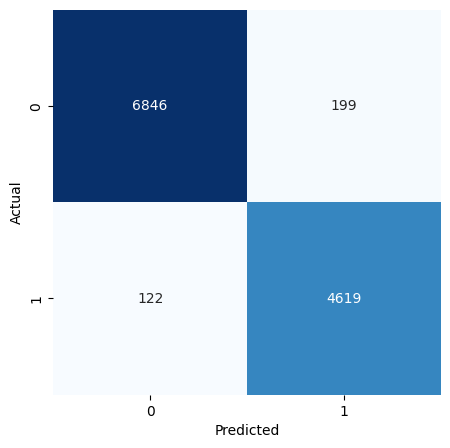

In [33]:
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

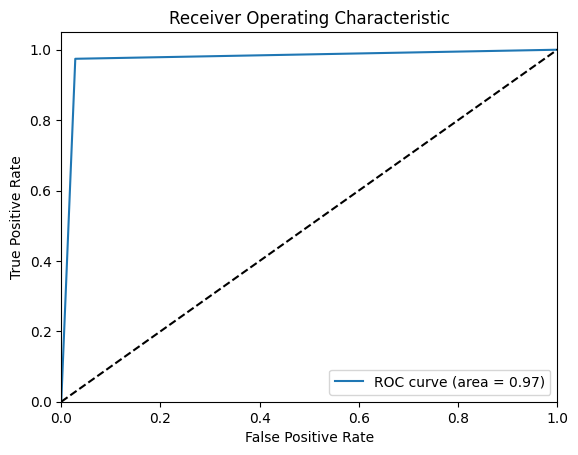

In [34]:
# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Classification with CatBoost
## Hyperparameters finetuning
## create the objective function

In [35]:
def cross_validation_catboost(datasets, k1, learning_rate, n_estimators, max_depth):
    """
    Effectue une validation croisée pour CatBoost en utilisant 4 fichiers pour le train
    et 1 pour le test, avec sélection de caractéristiques.

    :param datasets: Liste de DataFrames.
    :param k1: Nombre de caractéristiques à sélectionner.
    :param learning_rate: Taux d'apprentissage pour CatBoost.
    :param n_estimators: Nombre d'arbres (boosting rounds).
    :param max_depth: Profondeur maximale des arbres
    :return: Liste des résultats pour chaque combinaison.
    """

    results = []

    # Combinaisons des fichiers (4 pour le train, 1 pour le test)
    for combination in combinations(range(len(datasets)), 4):
        # Indices des fichiers de train et de test
        train_indices = [i + 1 for i in combination]
        test_index = [i + 1 for i in range(len(datasets)) if i not in combination][0]

        # Créer l'ensemble d'entraînement et de test
        train_data = pd.concat([datasets[i] for i in combination])
        test_data = datasets[[i for i in range(len(datasets)) if i not in combination][0]]

        # Séparer les features (X) et les labels (y)
        X_train, y_train = train_data.drop(columns=['label']), train_data['label']
        X_test, y_test = test_data.drop(columns=['label']), test_data['label']

        # Sélection des caractéristiques
        selector = SelectKBest(score_func=f_classif, k=int(k1))
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)

        # Entraîner le modèle CatBoost
        clf = CatBoostClassifier(
            learning_rate=learning_rate,
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            verbose=0
        )
        clf.fit(X_train_selected, y_train)

        # Prédire sur les données de test
        y_pred = clf.predict(X_test_selected)

        # Calculer le F1-score
        score = f1_score(y_test, y_pred, average='weighted')
        results.append((train_indices, test_index, score))

    return results

# Paramètres pour CatBoost
k1 = 14
learning_rate = 0.1
n_estimators = 100
max_depth = 3

# Lancer la validation croisée
results_catboost = cross_validation_catboost(datasets, k1, learning_rate, n_estimators, max_depth)

# Afficher les résultats
for i, (train_files, test_file, score) in enumerate(results_catboost, 1):
    print(f"### Combinaison {i} ###")
    print(f"Fichiers pour le train: {train_files}")
    print(f"Fichier pour le test: {test_file}")
    print(f"F1-score pour cette combinaison: {score:.4f}\n")

# Moyenne des F1-scores
mean_score_catboost = np.mean([score for _, _, score in results_catboost])
print(f"Moyenne des F1-scores (CatBoost) : {mean_score_catboost:.4f}")

# Écart-type des F1-scores
std_score_catboost = np.std([score for _, _, score in results_catboost])
print(f"Écart-type des F1-scores (CatBoost) : {std_score_catboost:.4f}")

### Combinaison 1 ###
Fichiers pour le train: [1, 2, 3, 4]
Fichier pour le test: 5
F1-score pour cette combinaison: 0.9338

### Combinaison 2 ###
Fichiers pour le train: [1, 2, 3, 5]
Fichier pour le test: 4
F1-score pour cette combinaison: 0.9581

### Combinaison 3 ###
Fichiers pour le train: [1, 2, 4, 5]
Fichier pour le test: 3
F1-score pour cette combinaison: 0.9758

### Combinaison 4 ###
Fichiers pour le train: [1, 3, 4, 5]
Fichier pour le test: 2
F1-score pour cette combinaison: 0.8885

### Combinaison 5 ###
Fichiers pour le train: [2, 3, 4, 5]
Fichier pour le test: 1
F1-score pour cette combinaison: 0.8725

Moyenne des F1-scores (CatBoost) : 0.9257
Écart-type des F1-scores (CatBoost) : 0.0396


In [36]:
def my_cb(k1, lr, n_est, md):
    """
    Fonction de validation croisée pour CatBoost.

    :param k1: Nombre de caractéristiques à sélectionner.
    :return: Moyenne des F1-scores.
    """
    # Perform feature selection
    selector = SelectKBest(score_func=f_classif, k=int(k1))
    X_selected = selector.fit_transform(X, y)
    X_selected = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

    # Split the data into training and testing sets
    X_train = pd.concat([data1, data2, data4, data5]).drop('label', axis=1)
    y_train = pd.concat([data1, data2, data4, data5])['label']
    X_test = data3.drop('label', axis=1)
    y_test = data3['label']

    # Select the features for the test data
    X_test = X_test[X_selected.columns]
    X_train = X_train[X_selected.columns]

    # Train the model
    clf = CatBoostClassifier(
        learning_rate=lr,
        n_estimators=int(n_est),
        max_depth=int(md),
        verbose=0
    )
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    return f1_score(y_test, y_pred)

### Finetuning using Bayesian Optimization

In [37]:
pbounds = {
    'k1': (5, 21),
    'lr': (0.01, 0.3),
    'n_est': (50, 200),
    'md': (2, 5)
}

optimizer = BayesianOptimization(
    f=my_cb,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

start = time.time()
optimizer.maximize(init_points=20, n_iter=20)
end = time.time()
print('Bayes optimization takes {:.2f} seconds to tune'.format(end - start))
print(optimizer.max)

|   iter    |  target   |    k1     |    lr     |    md     |   n_est   |
-------------------------------------------------------------------------
| 1         | 0.9591    | 11.67     | 0.2189    | 2.0       | 95.35     |
| 2         | 0.9289    | 7.348     | 0.03678   | 2.559     | 101.8     |
| 3         | 0.9619    | 11.35     | 0.1663    | 3.258     | 152.8     |
| 4         | 0.9578    | 8.271     | 0.2647    | 2.082     | 150.6     |
| 5         | 0.949     | 11.68     | 0.172     | 2.421     | 79.72     |
| 6         | 0.9683    | 17.81     | 0.2908    | 2.94      | 153.8     |
| 7         | 0.9694    | 19.02     | 0.2694    | 2.255     | 55.86     |
| 8         | 0.9262    | 7.717     | 0.2647    | 2.295     | 113.2     |
| 9         | 0.9694    | 20.33     | 0.1646    | 4.076     | 97.33     |
| 10        | 0.9692    | 15.98     | 0.252     | 2.055     | 162.5     |
| 11        | 0.9665    | 20.82     | 0.227     | 2.841     | 168.4     |
| 12        | 0.9285    | 6.652     | 

In [38]:
# Perform feature selection
selector = SelectKBest(score_func=f_classif, k=int(optimizer.max['params']['k1']))
X_selected = selector.fit_transform(X, y)

# Split the data into training and testing sets
X_train = pd.concat([data1, data2, data4, data5]).drop('label', axis=1)
y_train = pd.concat([data1, data2, data4, data5])['label']
X_test = data3.drop('label', axis=1)
y_test = data3['label']

# Select the features for the test data
X_test = X_test[X.columns[selector.get_support()]].to_numpy()
X_train = X_train[X.columns[selector.get_support()]].to_numpy()

# Create a CatBoostClassifier
model = CatBoostClassifier(
    learning_rate=optimizer.max['params']['lr'],
    n_estimators=int(optimizer.max['params']['n_est']),
    max_depth=int(optimizer.max['params']['md']),
    verbose=0
)

start = time.time()

# Train the classifier
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

execution_time = time.time() - start

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# ROC curve and AUC
macro_roc_auc = roc_auc_score(y_test.to_numpy(), y_pred, average="macro")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the TP, TN, FP, FN values
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Get the bias and variance of the classifier
loss, bias, var = bias_variance_decomp(model, X_train, y_train.to_numpy(), X_test, y_test.to_numpy(), loss='0-1_loss', random_seed=23)

# Print the evaluation metrics
print("Loss:", loss)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("TP:", TP.sum())
print("TN:", TN.sum())
print("FP:", FP.sum())
print("FN:", FN.sum())
print("AUC:", macro_roc_auc)
print("Bias:", bias)
print("Variance:", var)
print(f"Execution Time: {execution_time} seconds")

Loss: 0.02379433225861191
Accuracy: 0.9770914644493467
Precision: 0.9777013602059721
Recall: 0.9770914644493467
F1 Score: 0.9771572896954754
TP: 11516
TN: 11516
FP: 270
FN: 270
AUC: 0.9793198842706565
Bias: 0.023417614118445614
Variance: 0.0024418801968437128
Execution Time: 0.30855464935302734 seconds


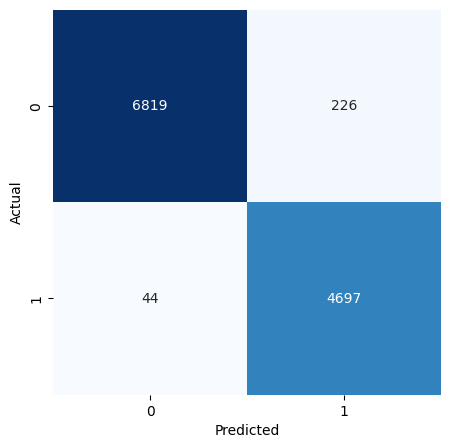

In [39]:
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

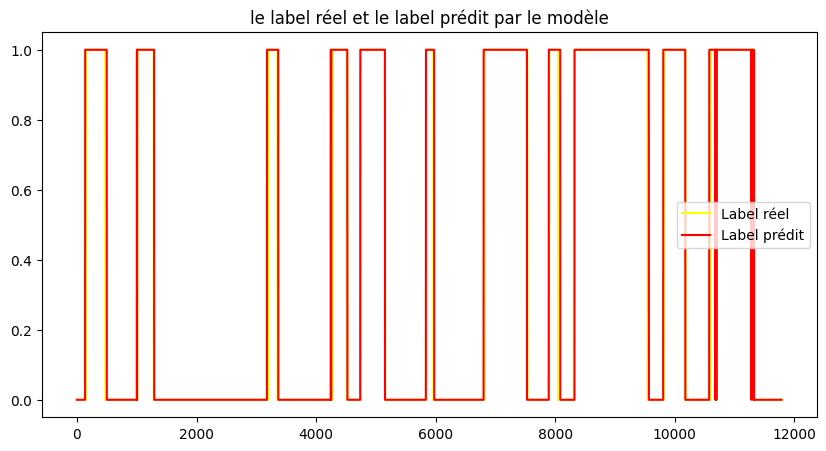

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Label réel',color='yellow')
plt.plot(y_pred, label='Label prédit',color='red')
plt.title('le label réel et le label prédit par le modèle')
plt.legend()
plt.show()

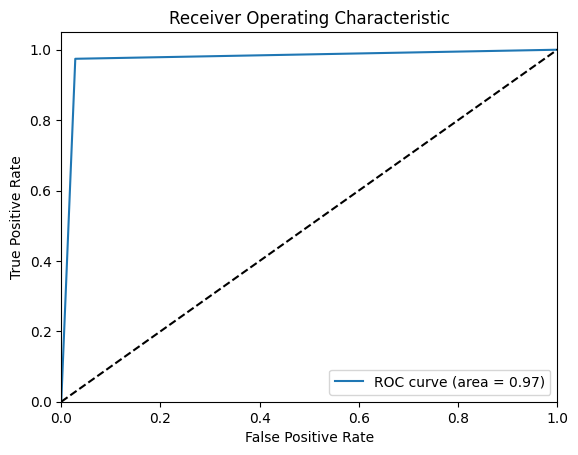

In [41]:
# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Classification with AdaBoost
## Hyperparameters finetuning
## create the objective function

In [43]:
def cross_validation_adaboost(datasets, k1, n_estimators, learning_rate):
    """
    Effectue une validation croisée pour AdaBoost en utilisant 4 fichiers pour le train
    et 1 pour le test, avec sélection de caractéristiques.

    :param datasets: Liste de DataFrames.
    :param k1: Nombre de caractéristiques à sélectionner.
    :param n_estimators: Nombre d'estimateurs.
    :param learning_rate: Taux d'apprentissage.
    :return: Liste des résultats pour chaque combinaison.
    """

    results = []

    # Combinaisons des fichiers (4 pour le train, 1 pour le test)
    for combination in combinations(range(len(datasets)), 4):
        # Indices des fichiers de train et de test
        train_indices = [i + 1 for i in combination]
        test_index = [i + 1 for i in range(len(datasets)) if i not in combination][0]

        # Créer l'ensemble d'entraînement et de test
        train_data = pd.concat([datasets[i] for i in combination])
        test_data = datasets[[i for i in range(len(datasets)) if i not in combination][0]]

        # Séparer les features (X) et les labels (y)
        X_train, y_train = train_data.drop(columns=['label']), train_data['label']
        X_test, y_test = test_data.drop(columns=['label']), test_data['label']

        # Sélection des caractéristiques
        selector = SelectKBest(score_func=f_classif, k=int(k1))
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)

        # Entraîner le modèle AdaBoost
        clf = AdaBoost(
            n_estimators=int(n_estimators),
            learning_rate=learning_rate
        )
        clf.fit(X_train_selected, y_train)

        # Prédire sur les données de test
        y_pred = clf.predict(X_test_selected)

        # Calculer le F1-score
        score = f1_score(y_test, y_pred, average='weighted')
        results.append((train_indices, test_index, score))

    return results

# Paramètres pour AdaBoost
k1 = 21
n_estimators = 50
learning_rate = 0.01

# Lancer la validation croisée
results_adaboost = cross_validation_adaboost(datasets, k1, n_estimators, learning_rate)

# Afficher les résultats
for i, (train_files, test_file, score) in enumerate(results_adaboost, 1):
    print(f"### Combinaison {i} ###")
    print(f"Fichiers pour le train: {train_files}")
    print(f"Fichier pour le test: {test_file}")
    print(f"F1-score pour cette combinaison: {score:.4f}\n")

# Moyenne des F1-scores
mean_score_adaboost = np.mean([score for _, _, score in results_adaboost])
print(f"Moyenne des F1-scores (AdaBoost) : {mean_score_adaboost:.4f}")

# Écart-type des F1-scores
std_score_adaboost = np.std([score for _, _, score in results_adaboost])
print(f"Écart-type des F1-scores (AdaBoost) : {std_score_adaboost:.4f}")

### Combinaison 1 ###
Fichiers pour le train: [1, 2, 3, 4]
Fichier pour le test: 5
F1-score pour cette combinaison: 0.9050

### Combinaison 2 ###
Fichiers pour le train: [1, 2, 3, 5]
Fichier pour le test: 4
F1-score pour cette combinaison: 0.9621

### Combinaison 3 ###
Fichiers pour le train: [1, 2, 4, 5]
Fichier pour le test: 3
F1-score pour cette combinaison: 0.9426

### Combinaison 4 ###
Fichiers pour le train: [1, 3, 4, 5]
Fichier pour le test: 2
F1-score pour cette combinaison: 0.8996

### Combinaison 5 ###
Fichiers pour le train: [2, 3, 4, 5]
Fichier pour le test: 1
F1-score pour cette combinaison: 0.6512

Moyenne des F1-scores (AdaBoost) : 0.8721
Écart-type des F1-scores (AdaBoost) : 0.1129


In [46]:
def my_ad(k1, n_est, lr):
    """
    Fonction de validation croisée pour AdaBoost.

    :param k1: Nombre de caractéristiques à sélectionner.
    :return: Moyenne des F1-scores.
    """
    # Perform feature selection
    selector = SelectKBest(score_func=f_classif, k=int(k1))
    X_selected = selector.fit_transform(X, y)
    X_selected = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

    # Split the data into training and testing sets
    X_train = pd.concat([data1, data2, data3, data5]).drop('label', axis=1)
    y_train = pd.concat([data1, data2, data3, data5])['label']
    X_test = data4.drop('label', axis=1)
    y_test = data4['label']

    # Select the features for the test data
    X_test = X_test[X_selected.columns]
    X_train = X_train[X_selected.columns]

    # Train the model
    clf = AdaBoost(
        n_estimators=int(n_est),
        learning_rate=lr
    )
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    return f1_score(y_test, y_pred)

## Finetuning using Bayesian Optimization

In [48]:
pbounds = {
    'k1': (5, 21),
    'n_est': (50, 200),
    'lr': (0.01, 0.3),
}

optimizer = BayesianOptimization(
    f=my_ad,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

start = time.time()
optimizer.maximize(init_points=10, n_iter=10)
end = time.time()

print('Bayes optimization takes {:.2f} seconds to tune'.format(end - start))
print(optimizer.max)

|   iter    |  target   |    k1     |    lr     |   n_est   |
-------------------------------------------------------------
| 1         | 0.9736    | 11.67     | 0.2189    | 50.02     |
| 2         | 0.9703    | 9.837     | 0.05256   | 63.85     |
| 3         | 0.9712    | 7.98      | 0.1102    | 109.5     |
| 4         | 0.9654    | 13.62     | 0.1316    | 152.8     |
| 5         | 0.9716    | 8.271     | 0.2647    | 54.11     |
| 6         | 0.9582    | 15.73     | 0.131     | 133.8     |
| 7         | 0.9711    | 7.246     | 0.06745   | 170.1     |
| 8         | 0.9607    | 20.49     | 0.1009    | 153.8     |
| 9         | 0.9562    | 19.02     | 0.2694    | 62.76     |
| 10        | 0.9713    | 5.625     | 0.05925   | 181.7     |
| 11        | 0.9726    | 12.73     | 0.2775    | 177.0     |
| 12        | 0.9628    | 15.59     | 0.08044   | 186.7     |
| 13        | 0.9617    | 15.99     | 0.2264    | 170.6     |
| 14        | 0.9711    | 7.685     | 0.06562   | 176.2     |
| 15    

## perform binary classifcation

In [49]:
# Perform feature selection
selector = SelectKBest(score_func=f_classif, k=int(optimizer.max['params']['k1']))
X_selected = selector.fit_transform(X, y)

# Split the data into training and testing sets
X_train = pd.concat([data1, data2, data3, data5]).drop('label', axis=1)
y_train = pd.concat([data1, data2, data3, data5])['label']

X_test = data4.drop('label', axis=1)
y_test = data4['label']

# Select the features for the test data
X_test = X_test[X.columns[selector.get_support()]].to_numpy()
X_train = X_train[X.columns[selector.get_support()]].to_numpy()

# Create an AdaBoostClassifier
model = AdaBoost(
    n_estimators=int(optimizer.max['params']['n_est']),
    learning_rate=optimizer.max['params']['lr']
)

start = time.time()

# Train the classifier
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

execution_time = time.time() - start

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# ROC curve and AUC
macro_roc_auc = roc_auc_score(y_test.to_numpy(), y_pred, average="macro")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the TP, TN, FP, FN values
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Get the bias and variance of the classifier
loss, bias, var = bias_variance_decomp(model, X_train, y_train.to_numpy(), X_test, y_test.to_numpy(), loss='0-1_loss', random_seed=23)

# Print the evaluation metrics
print("Loss:", loss)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("TP:", TP.sum())
print("TN:", TN.sum())
print("FP:", FP.sum())
print("FN:", FN.sum())
print("AUC:", macro_roc_auc)
print("Bias:", bias)
print("Variance:", var)
print(f"Execution Time: {execution_time} seconds")

Loss: 0.03461937716262976
Accuracy: 0.9659385813148789
Precision: 0.9666470971047266
Recall: 0.9659385813148789
F1 Score: 0.966090420754202
TP: 8933
TN: 8933
FP: 315
FN: 315
AUC: 0.9671275040874634
Bias: 0.034169550173010384
Variance: 0.0027043685121107266
Execution Time: 5.219361066818237 seconds


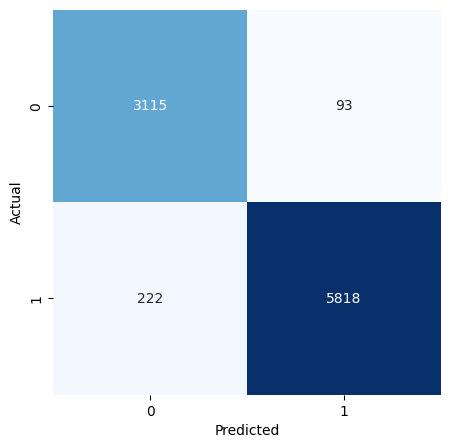

In [50]:
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

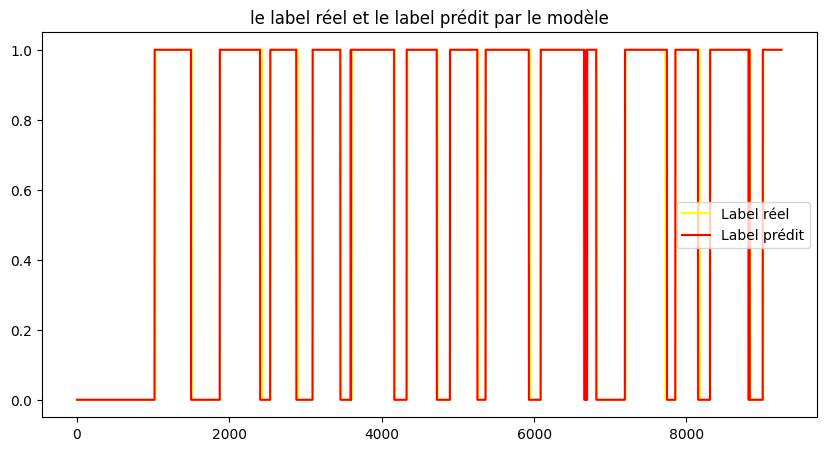

In [51]:
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Label réel',color='yellow')
plt.plot(y_pred, label='Label prédit',color='red')
plt.title('le label réel et le label prédit par le modèle')
plt.legend()
plt.show()

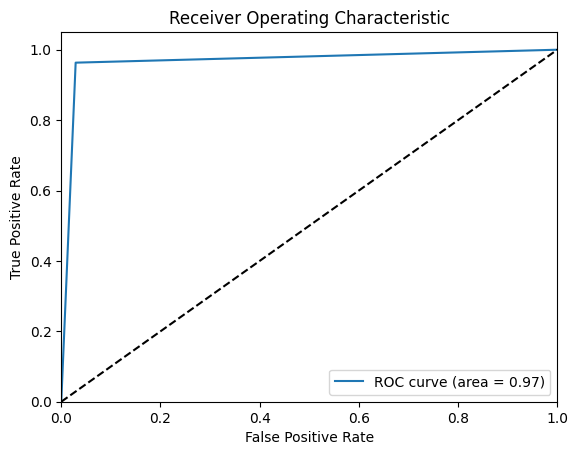

In [52]:
# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()